1. Create a part of mapping files: smp_2_ltcd; ltcd_2_smp;species_smps; smp_2_size; smp_2_donor; smp_2_sp; Alignment_rate
2. Read in plasmid basic information: size, copy number, sequences
3. Read in genomad annotations
4. Read in PLSDB matching files
5. Sample and Donor Selection based on Size and Alignment
6. Plasmid Clustering and Filtering
7. Plot Figure 3A
8. Get species-2-phylum match
9. Plot Figure 3B
10. Plot Figure 3C

In [1]:
# Representative isolates per donor setting
# Representative_isolates_per_donor = False
Representative_isolates_per_donor = False

# Mapping file to convert names used for clustering
smp_2_ltcd = {}
ltcd_2_smp = {}

# Read the mapping file
with open('files/plasmid-mapping-LtCd-to-smp.csv') as file:
    lines = file.readlines()
    
    # Extract data and populate dictionaries
    for line in lines:
        data = line.strip().split(',')
        smp, ltcd = data[0], data[1]
        
        smp_2_ltcd[smp] = ltcd
        ltcd_2_smp[ltcd] = smp

# Species mapping dictionaries
species_smps = {}
smp_2_size = {}
smp_2_donor = {}
smp_2_species = {}
smp_2_align = {}
species_2_phylum = {}
smp_2_phylum = {}
Filtered_Species_smplist = {}
Filtered_Species_donorlist = {}
Filtered_Species_sizelist = {}

# Read filtered samples file
with open('../Intermediary-files/filtered_samples.csv') as file:
    for line in file:
        # Parse each line
        if 'GenomeSize' not in line:
            smp, sp, size, donor, align, phylum = line.strip().split(',')[0], line.strip().split(',')[1], int(line.strip().split(',')[2]), line.strip().split(',')[3], line.strip().split(',')[4], line.strip().split(',')[7]
            # Populate dictionaries
            smp_2_size[smp] = size
            smp_2_donor[smp] = donor
            smp_2_species[smp] = sp
            smp_2_align[smp] = align
            smp_2_phylum[smp] = phylum
            species_2_phylum[sp] = phylum
            # Add to filtered species lists
            if sp not in Filtered_Species_smplist:
                Filtered_Species_smplist[sp] = []
                Filtered_Species_donorlist[sp] = {}
                Filtered_Species_sizelist[sp] = []
            Filtered_Species_smplist[sp].append(smp)
            Filtered_Species_sizelist[sp].append(size)
            if donor not in Filtered_Species_donorlist[sp]:
                Filtered_Species_donorlist[sp][donor] = []
            Filtered_Species_donorlist[sp][donor].append(smp)
            species_smps.setdefault(sp, []).append(smp)

# Alignment rate dictionary
Alignment_rate = {}

# Read alignment results file
with open('files/mapping-results.raw.format.txt') as g:
    lines = g.readlines()
    for line in lines:
        # Parse each line
        smp = line.split('/')[1]
        ali = float(line.split('(')[1].split('%')[0])
        # Populate alignment rate dictionary
        Alignment_rate[smp] = ali


In [2]:
# 2. Read in plasmid basic information: size, copy number, sequences
plasmid_2_depth = {}
plasmid_2_size = {}
plasmid_2_seq = {}
with open('../Intermediary-files/plasmids/plasmids-all.fasta') as file:
    lines = file.readlines()
    for line in lines:
        if line[0]=='>':
            tmp = line.split(' ')
            PlLtCd = tmp[0][1:]
            pl_size = int(tmp[2].split('=')[1])
            pl_dep = float(tmp[3].split('=')[1].split('x')[0])
            plasmid_2_depth[PlLtCd]=pl_dep
            plasmid_2_size[PlLtCd]=pl_size
            plasmid_2_seq[PlLtCd]=''
        else:
            plasmid_2_seq[PlLtCd]=plasmid_2_seq[PlLtCd]+line.split('\n')[0]

In [3]:
# 3. Read in genomad annotations
classification={}
with open('../Intermediary-files/plasmids/merge_nn_classification.tsv') as g:
    lines = g.readlines()
    for line in lines:
        tmp = line.split('\t')
        if tmp[0][0]=='P':
            ClusterID = tmp[0].split('_')[0]+'_'+tmp[0].split('_')[1]
            classification[ClusterID]=[float(tmp[1]),float(tmp[2]),float(tmp[3].split('\n')[0])]

In [4]:
# 4. Read in PLSDB matching files
plsdb_record = {}
with open('../Intermediary-files/plasmids/plsdb-rep-comparison-output') as g:
    lines = g.readlines()
    for line in lines:
        tmp = line.split('\t')
        PID = tmp[1].split('/')[1].split('_')[0]+'_'+tmp[1].split('/')[1].split('_')[1]
        dist = float(tmp[2])
        if dist < 0.1:
            if PID not in plsdb_record:
                plsdb_record[PID]=dist
            if dist < plsdb_record[PID]:
                plsdb_record[PID]=dist
len(plsdb_record)

751

In [5]:
# 5. Sample and Donor Selection based on Size and Alignment

import numpy as np
# Dictionary to store good donors for each species
Species_good_donor_list = {}

# Lists to store good samples and their LtCd values
Goodsamples = []
GoodLtCd = []

# Define the threshold for acceptable sample size deviation
sigma = 2

# Iterate through species and their samples
for species, samples in species_smps.items():
    # Get the list of sample sizes for the current species
    sizelist = [smp_2_size[smp] for smp in samples]

    # Calculate median and standard deviation of sample sizes for the current species
    sz_md = np.median(sizelist)
    sz_st = np.std(sizelist)

    # Initialize a set to store good donors for the current species
    good_donors = set()

    # Initialize a counter for samples within the acceptable size range
    in_range = 0

    # Check each sample's size
    for smp in samples:
        size = smp_2_size[smp]
        alignmentrate = Alignment_rate[smp]

        # Check if the sample size is within the acceptable range or if the sample size data is limited
        if (sz_md - sigma * sz_st < size < sz_md + sigma * sz_st or len(sizelist) < 5) and (sz_md * 0.8 < size < sz_md * 1.2) and alignmentrate > 95:
            donor = smp_2_donor[smp]
            batchinformation = 'IBD-' not in smp and 'Bact-' not in smp

            # Check if Representative_isolates_per_donor is True
            if Representative_isolates_per_donor:
                # Check if the donor is not already in the set of good donors and if batch information is True
                if donor not in good_donors and batchinformation:
                    # Add the donor to the set of good donors
                    good_donors.add(donor)
                    in_range += 1
                    # Add the good sample to the lists
                    Goodsamples.append(smp)
                    GoodLtCd.append(smp_2_ltcd[smp])
                # Uncomment the following lines if you want to handle cases where batch information is False
                # elif donor not in good_donors and not batchinformation:
                #     Tmp_species_good_donors[species][donor] = smp

            # If Representative_isolates_per_donor is False, add the donor to the set of good donors
            else:
                good_donors.add(donor)
                in_range += 1
                # Add the good sample to the lists
                Goodsamples.append(smp)
                GoodLtCd.append(smp_2_ltcd[smp])

    # Store the set of good donors for the current species
    Species_good_donor_list[species] = dict.fromkeys(good_donors)

    # # Print the species name and the number of samples within the acceptable range
    # print(species, in_range)


In [6]:
# 6. Plasmid Clustering and Filtering

# Initialize dictionaries to store plasmid depth information
Plasmid_DS_by_cluster = {}
Plasmid_DS_by_species = {}

# Dictionary to store clean plasmid clusters
Plasmid_clean_DS = {}

# Define the depth cutoff threshold
dep_cutoff = 0.9

# Read the clustering information from a file
with open('../Intermediary-files/plasmids/pilot-cluster.txt') as file:
    lines = file.readlines()
    
    # Iterate through the lines in the file
    for line in lines:
        tmp = line.split('\t')
        
        # Check if the line starts with '>'
        if line[0] == '>':
            ClusterID = line[1:-1]  # Extract the ClusterID
        else:
            size = int(tmp[1])
            PlLtCd = tmp[3]
            LtCd = tmp[3].split('_')[0]

            # Check if LtCd is present in ltcd_2_smp mapping
            if LtCd in ltcd_2_smp:
                smp = ltcd_2_smp[LtCd]
                
                # Check if smp is associated with a species
                if smp in smp_2_species:
                    species = smp_2_species[smp]
                    pl_dep = plasmid_2_depth[PlLtCd]
                    
                    # Check if plasmid depth is above the cutoff and LtCd is in GoodLtCd list
                    if pl_dep > dep_cutoff and LtCd in GoodLtCd:
                        
                        # Create entries in the dictionaries for clustering by species and cluster by cluster
                        Plasmid_DS_by_cluster.setdefault(ClusterID, {}).setdefault(species, {})[PlLtCd] = 1
                        Plasmid_DS_by_species.setdefault(species, {}).setdefault(ClusterID, {})[PlLtCd] = 1
                        
                        # Add the PlLtCd to the clean plasmid cluster list
                        Plasmid_clean_DS.setdefault(ClusterID, []).append(PlLtCd)


In [7]:
len(Plasmid_clean_DS)

1074

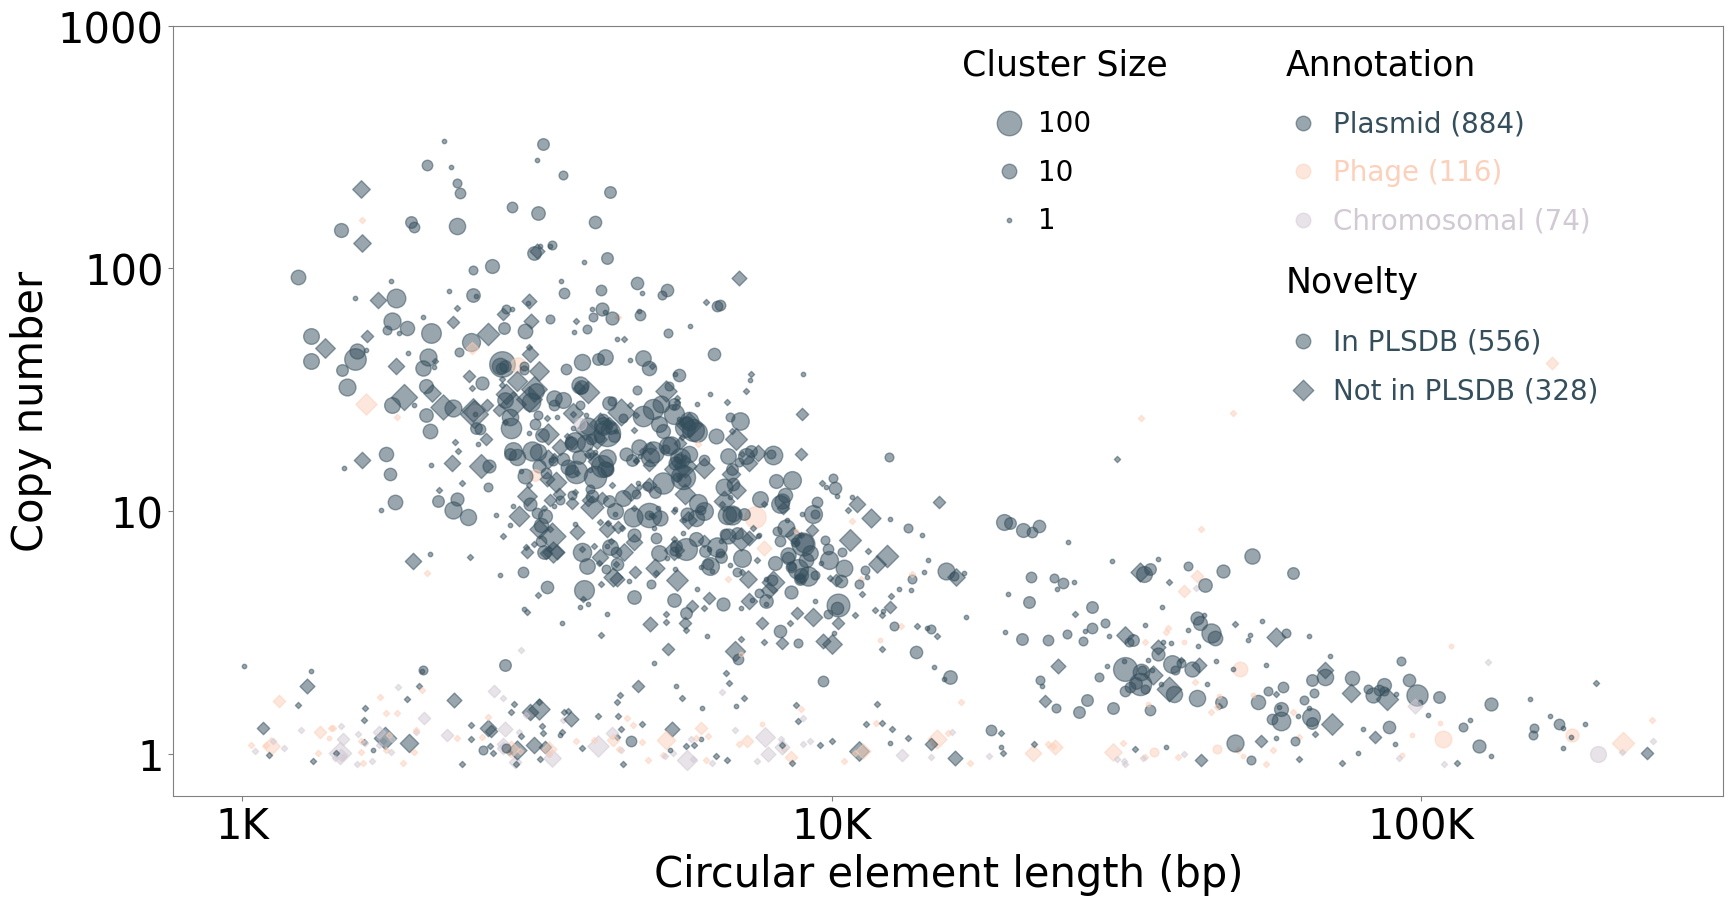

number of plasmid elements:  884
number of phage elements:  116
number of chromosomal elements:  74
number of plasmid in the PLSDB:  556
number of plasmid not in the PLSDB:  328
largest copy number:  335.82
largest contig size:  241869.5
smallest contig size:  1005.0


In [8]:
# 7. Plot Figure 3A
## This plot requires Representative_isolates_per_donor = False
## While all other sub-plots require the opposite
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.colors as mcolors

f = open('Table-S3-1.csv','w')

f.write('Plasmid_ID,Genome_ID,Species,Copy_Number,Size,Plasmid_Cluster_ID,In_PLSDB\n')

Annotation_type_numbers=[0,0,0]
smallestsize=100000
largestsize=0
mksize_base=100
inPLSDB=0
newPLSDB=0
largest_copy_num=0
# Define colors and labels for plotting
colors = ['#D1C9D3', '#344E5C', '#FCD0BA']
labels = ['Chromosome', 'Plasmid', 'Phage']

New_Plasmid_group_size=[]
Existing_Plasmid_group_size=[]

Confirmed_plasmid={}

# Create a figure with specified size
fig, ax = plt.subplots(figsize=(20, 10))  # Set the width and height in inches

# Iterate through plasmid clusters
for ClusterID, PlLtCds in Plasmid_clean_DS.items():
    # Extract depth and contig length information
    depth_list = [plasmid_2_depth[PlLtCd] for PlLtCd in PlLtCds]
    contig_length_list = [plasmid_2_size[PlLtCd] for PlLtCd in PlLtCds]
    
    # Determine the PVC class index with maximum value
    PVC_class = classification[ClusterID]
    PVC_idx = PVC_class.index(max(PVC_class))
    
    # Calculate average contig length and depth
    x = np.log10(np.median(contig_length_list))
    y = np.log10(np.median(depth_list))
    if np.median(depth_list)>largest_copy_num:
        largest_copy_num=np.median(depth_list)
    if np.median(contig_length_list)<smallestsize and PVC_idx==1:
        smallestsize=np.median(contig_length_list)
    if np.median(contig_length_list)>largestsize and PVC_idx==1:
        largestsize=np.median(contig_length_list)

    # Determine marker and label based on whether ClusterID is in plsdb_record
    marker = 'o' if ClusterID in plsdb_record else 'D'
    label = labels[PVC_idx] # if ClusterID in plsdb_record else None

    if PVC_idx==1:
        Confirmed_plasmid[ClusterID]=1
    if ClusterID in plsdb_record:
        Existing_Plasmid_group_size.append(len(PlLtCds))
    elif PVC_idx==1:
        New_Plasmid_group_size.append(len(PlLtCds))

    if PVC_idx==1:
        for PlLtCd in PlLtCds:
            LtCd=PlLtCd.split('_')[0]
            
            f.write(PlLtCd+','+ltcd_2_smp[LtCd]+','+smp_2_species[ltcd_2_smp[LtCd]]+',')
            f.write(str(plasmid_2_depth[PlLtCd])+','+str(plasmid_2_size[PlLtCd])+','+ClusterID.split('_')[0]+',')
            if ClusterID in plsdb_record:
                f.write('Yes'+',')
            else:
                f.write('No'+',')
            f.write('\n')
            
    
    # Calculate marker size based on the logarithm of the number of PlLtCds
    marker_size = mksize_base * (np.log10(len(PlLtCds)) + 0.1)
    if PVC_idx==1:
        if ClusterID in plsdb_record:
            inPLSDB+=1
        else:
            newPLSDB+=1
    
    # Scatter plot
    rgb_color = mcolors.to_rgba(colors[PVC_idx])[:3]
    ec = [rgb_color[0],rgb_color[1],rgb_color[2],0.1]
    plt.scatter(x, y, color=colors[PVC_idx], alpha=0.5, s=marker_size, edgecolors=ec, marker=marker, label=label)
    Annotation_type_numbers[PVC_idx]+=1
    
x=4.3
y=2.2
shift = 0.035

plt.scatter(x,y, color=colors[1], alpha=0.5, s=mksize_base * (np.log10(1) + 0.1), edgecolors=colors[1], marker='o')
plt.text(x+0.05,y-shift,'1',color='k',fontsize=20)

plt.scatter(x,y+0.2, color=colors[1], alpha=0.5, s=mksize_base * (np.log10(10) + 0.1), edgecolors=colors[1], marker='o')
plt.text(x+0.05,y+0.2-shift,'10',color='k',fontsize=20)

plt.scatter(x,y+0.4, color=colors[1], alpha=0.5, s=mksize_base * (np.log10(1000) + 0.1), edgecolors=colors[1], marker='o')
plt.text(x+0.05,y+0.4-shift,'100',color='k',fontsize=20)
plt.text(x-0.08,y+0.6,'Cluster Size',color='k',fontsize=25)



x=4.8
y=2.2
plt.scatter(x,y, color=colors[0], alpha=0.5, s=mksize_base * (np.log10(10) + 0.1), edgecolors=colors[0], marker='o')
plt.text(x+0.05,y-shift,'Chromosomal ('+str(Annotation_type_numbers[0])+')',color=colors[0],fontsize=20)

plt.scatter(x,y+0.2, color=colors[2], alpha=0.5, s=mksize_base * (np.log10(10) + 0.1), edgecolors=colors[2], marker='o')
plt.text(x+0.05,y+0.2-shift,'Phage ('+str(Annotation_type_numbers[2])+')',color=colors[2],fontsize=20)

plt.scatter(x,y+0.4, color=colors[1], alpha=0.5, s=mksize_base * (np.log10(10) + 0.1), edgecolors=colors[1], marker='o')
plt.text(x+0.05,y+0.4-shift,'Plasmid ('+str(Annotation_type_numbers[1])+')',color=colors[1],fontsize=20)
plt.text(x-0.03,y+0.6,'Annotation',color='k',fontsize=25)

x=4.8
y=1.5
plt.scatter(x,y, color=colors[1], alpha=0.5, s=mksize_base * (np.log10(10) + 0.1), edgecolors=colors[1], marker='D')
plt.text(x+0.05,y-shift,'Not in PLSDB ('+str(newPLSDB)+')',color=colors[1],fontsize=20)

plt.scatter(x,y+0.2, color=colors[1], alpha=0.5, s=mksize_base * (np.log10(10) + 0.1), edgecolors=colors[1], marker='o')
plt.text(x+0.05,y+0.2-shift,'In PLSDB ('+str(inPLSDB)+')',color=colors[1],fontsize=20)
plt.text(x-0.03,y+0.4,'Novelty',color='k',fontsize=25)


# # Set x and y scales to logarithmic
# plt.xscale('log')
# plt.yscale('log')

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')  # Make the left axis line gray
ax.spines['bottom'].set_color('gray')  # Make the bottom axis line gray
ax.spines['top'].set_color('gray')  # Make the left axis line gray
ax.spines['right'].set_color('gray')  # Make the bottom axis line gray
ax.xaxis.set_tick_params(color='gray', direction='out')
ax.yaxis.set_tick_params(color='gray', direction='out')

# Customize tick values and labels
custom_xticks = [3,4,5]
present_xticks = ['1K','10K','100K']
custom_yticks = [0,1,2,3]
present_yticks = [1,10,100,1000]
plt.xticks(custom_xticks, present_xticks,fontsize=30)
plt.yticks(custom_yticks, present_yticks,fontsize=30)


plt.xlabel('Circular element length (bp)', fontsize=30)
plt.ylabel('Copy number', fontsize=30)

# Save the plot as a PDF file
plt.savefig('figures/Figure3A.pdf')

# Display the plot
plt.show()

print('number of plasmid elements: ',Annotation_type_numbers[1])
print('number of phage elements: ',Annotation_type_numbers[2])
print('number of chromosomal elements: ',Annotation_type_numbers[0])
print('number of plasmid in the PLSDB: ',inPLSDB)
print('number of plasmid not in the PLSDB: ',newPLSDB)
print('largest copy number: ',largest_copy_num)
print('largest contig size: ',largestsize)
print('smallest contig size: ',smallestsize)
f.close()

In [9]:
ClusterID

'PL-2136_2'

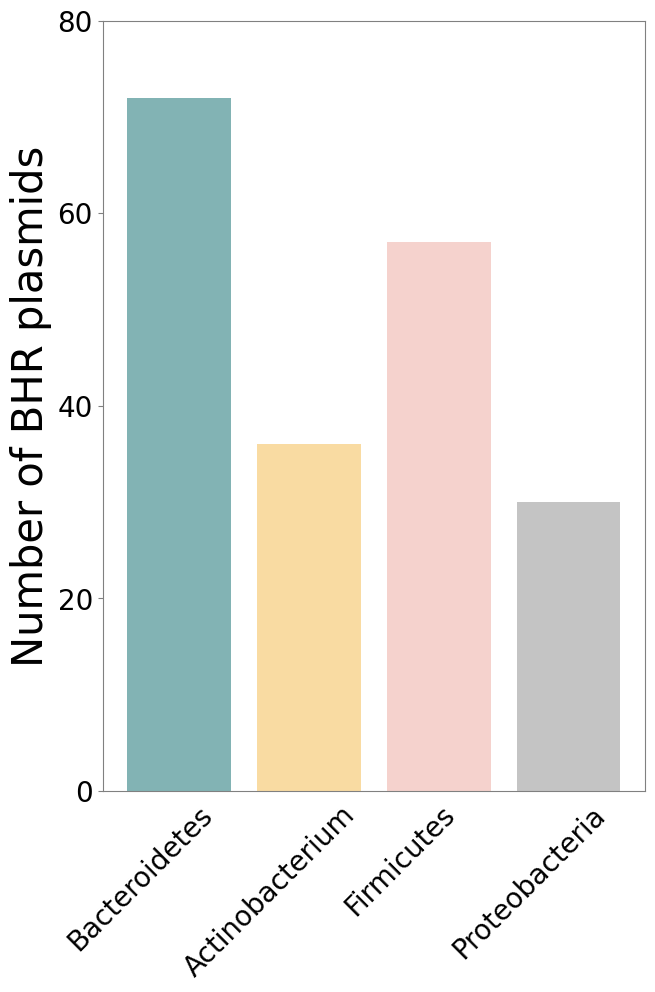

number of species with plasmid:  164
number of BHR:  195
number of BHR by phylum:  Bacteroidetes 72
number of BHR by phylum:  Actinobacteria 36
number of BHR by phylum:  Firmicutes 57
number of BHR by phylum:  Proteobacteria 30


In [10]:
# 9. Plot Figure 3B
import matplotlib.pyplot as plt
from collections import Counter
fig, ax = plt.subplots(figsize=(7,10))  # Set the width and height in inches

# Initialize dictionaries to store data
BHR_PID_2_phylum = {}
Phylum_BHR_PID_list = {}

# Iterate through plasmid clusters
Species_with_plasmid={}
for PID, SpeciesList in Plasmid_DS_by_cluster.items():
    if PID in Confirmed_plasmid:
        for species in SpeciesList:
            Species_with_plasmid[species]=1
        if len(SpeciesList) > 1:
            # Create a list to store phyla for each species in the cluster
            phyla_list = [species_2_phylum[Species] for Species in SpeciesList]
            
            # Count the occurrences of each phylum in the list
            phyla_counts = Counter(phyla_list)
            
            # Find the most common phylum and its count
            most_common_phylum, count = phyla_counts.most_common(1)[0]
            BHR_PID_2_phylum[PID] = most_common_phylum
            
            # Create a list of plasmid clusters for each most common phylum
            if most_common_phylum not in Phylum_BHR_PID_list:
                Phylum_BHR_PID_list[most_common_phylum] = []
            Phylum_BHR_PID_list[most_common_phylum].append(PID)

# Define colors for phyla
phylum_colors = {
    'Bacteroidetes': '#4D9394',
    'Actinobacteria': '#F7CC7B',
    'Proteobacteria': '#ABABAB',
    'Firmicutes': '#F2BFB8'
}

# Initialize lists for the bar plot
data = []
labels = []
colors = []

# Populate data, labels, and colors lists
for phylum in Phylum_BHR_PID_list:
    data.append(len(Phylum_BHR_PID_list[phylum]))
    labels.append(phylum)
    colors.append(phylum_colors.get(phylum, 'gray'))

# Create the bar plot
plt.bar(labels, data, width=0.8,color=colors,alpha=0.7)
plt.xticks(rotation=45)

# # Customize axis appearance
# ax = plt.gca()
# ax.spines['left'].set_color('gray')
# ax.spines['bottom'].set_color('gray')
# ax.spines['top'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.xaxis.set_tick_params(color='gray', direction='out')
# ax.yaxis.set_tick_params(color='gray', direction='out')


# Set the x-axis and y-axis tick color to black
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')
# Set the x-axis and y-axis line color to black
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# Change the font size of x-axis and y-axis labels
plt.ylabel("Number of BHR plasmids", fontsize=30)

# Customize x-axis tick labels
shift=0.3
x_ticks_positions = [0-shift,1-shift,2-shift,3-shift]  # Positions where custom labels will be placed
cus_x_ticks_positions = ['Bacteroidetes','Actinobacterium','Firmicutes','Proteobacteria']
plt.xticks(x_ticks_positions, cus_x_ticks_positions, fontsize=20)

# # Customize x-axis tick labels
x_ticks_positions = [0,20,40,60,80]  # Positions where custom labels will be placed
cus_x_ticks_positions=["1K","10K","100K"]
plt.yticks(x_ticks_positions, x_ticks_positions, fontsize=20)

# Remove tick marks on the x-axis
plt.tick_params(axis='x', bottom=False)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('gray')  # Make the left axis line gray
ax.spines['bottom'].set_color('gray')  # Make the bottom axis line gray
ax.spines['top'].set_color('gray')  # Make the left axis line gray
ax.spines['right'].set_color('gray')  # Make the bottom axis line gray
ax.xaxis.set_tick_params(color='gray', direction='out')
ax.yaxis.set_tick_params(color='gray', direction='out')

# Save the plot as a PDF file
fig.savefig('figures/Figure3B.pdf', dpi=600, bbox_inches='tight')


# Show the plot
plt.show()
print('number of species with plasmid: ', len(Species_with_plasmid))
print('number of BHR: ',len(BHR_PID_2_phylum))
for phylum in Phylum_BHR_PID_list:
    print('number of BHR by phylum: ',phylum, len(Phylum_BHR_PID_list[phylum]))

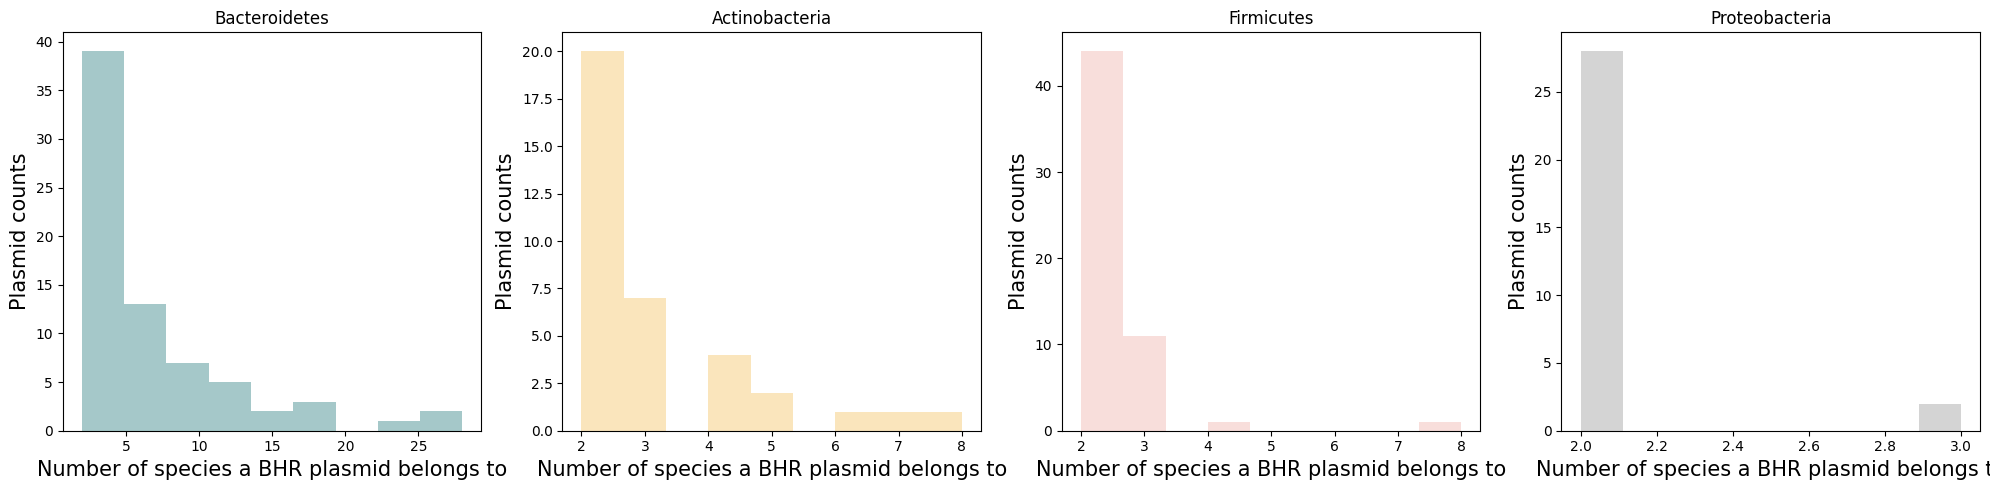

In [13]:
## Plot Figure S3A
import matplotlib.pyplot as plt
import numpy as np


datas=[]
plylalist=[]
for phylum in Phylum_BHR_PID_list:
    bhr_nums=[]
    for PID in Phylum_BHR_PID_list[phylum]:
        if PID in Confirmed_plasmid:
            bhr_nums.append(len(Plasmid_DS_by_cluster[PID]))
    datas.append(np.array(bhr_nums))
    plylalist.append(phylum)

data1=datas[0]
data2=datas[1]
data3=datas[2]
data4=datas[3]

# Creating the histogram bins
bins = np.linspace(min(data1.min(), data2.min(), data3.min(), data4.min()), 
                   max(data1.max(), data2.max(), data3.max(), data4.max()), 20)

# Creating subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plotting the histograms in subplots
for i in range(4):
    phylum = plylalist[i]
    bins = np.linspace(min(datas[i]), max(datas[i]), 10)
    axs[i].hist(datas[i], bins=bins, alpha=0.5, color=phylum_colors[phylum])
    axs[i].set_title(phylum)
    axs[i].set_xlabel('Number of species a BHR plasmid belongs to',fontsize=15)  # Add X-axis label
    axs[i].set_ylabel('Plasmid counts',fontsize=15)  # Add Y-axis label

    


# Displaying the plots
plt.tight_layout()
plt.savefig('figures/FigureS3A.pdf')
plt.show()

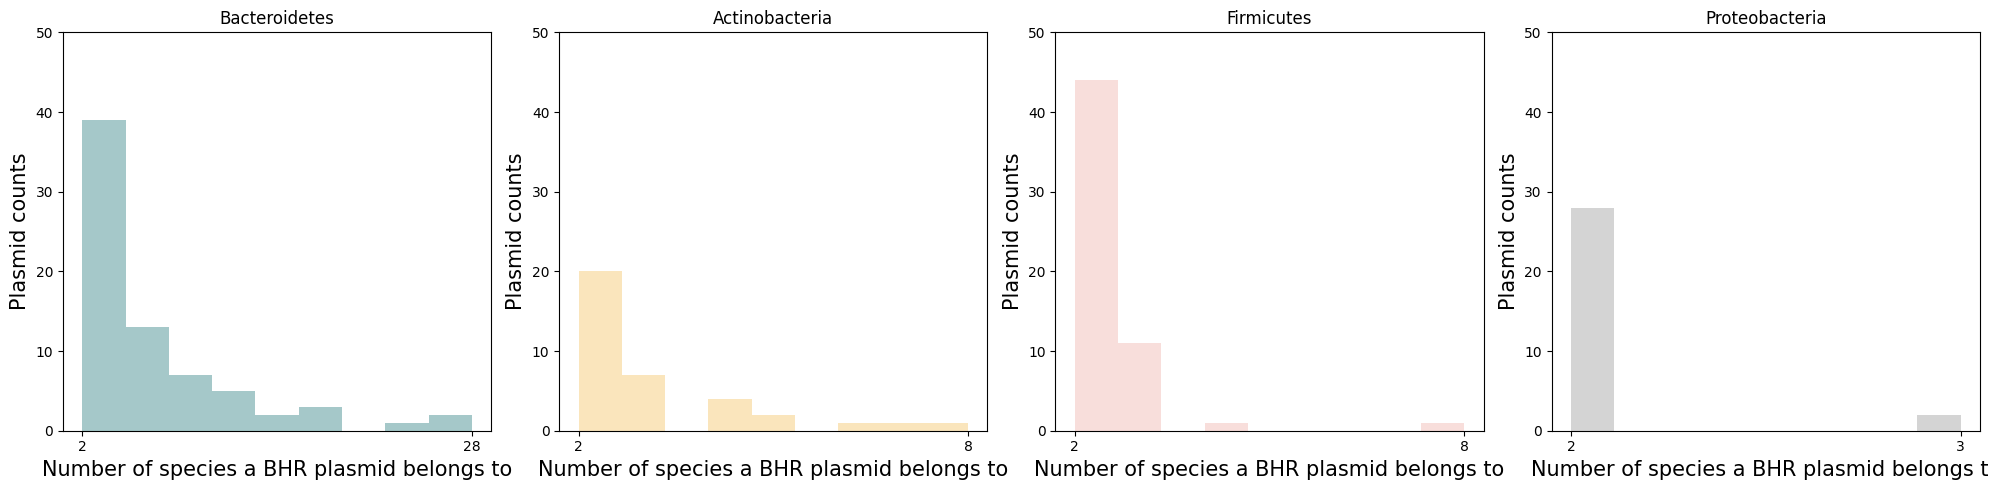

In [16]:
import matplotlib.pyplot as plt
import numpy as np

datas = []
plylalist = []
for phylum in Phylum_BHR_PID_list:
    bhr_nums = []
    for PID in Phylum_BHR_PID_list[phylum]:
        if PID in Confirmed_plasmid:
            bhr_nums.append(len(Plasmid_DS_by_cluster[PID]))
    datas.append(np.array(bhr_nums))
    plylalist.append(phylum)

data1 = datas[0]
data2 = datas[1]
data3 = datas[2]
data4 = datas[3]

# Creating subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Plotting the histograms in subplots
for i in range(4):
    phylum = plylalist[i]
    bins = np.linspace(min(datas[i]), max(datas[i]), 10)
    axs[i].hist(datas[i], bins=bins, alpha=0.5, color=phylum_colors[phylum])
    axs[i].set_title(phylum)
    axs[i].set_xlabel('Number of species a BHR plasmid belongs to', fontsize=15)  # Add X-axis label
    axs[i].set_ylabel('Plasmid counts', fontsize=15)  # Add Y-axis label
    axs[i].set_ylim([0, 50])  # Set y-limits

    # Customize x-axis tick labels
    axs[i].set_xticks([min(datas[i]), max(datas[i])])

# Displaying the plots
plt.tight_layout()
plt.savefig('figures/FigureS3A.pdf')
plt.show()


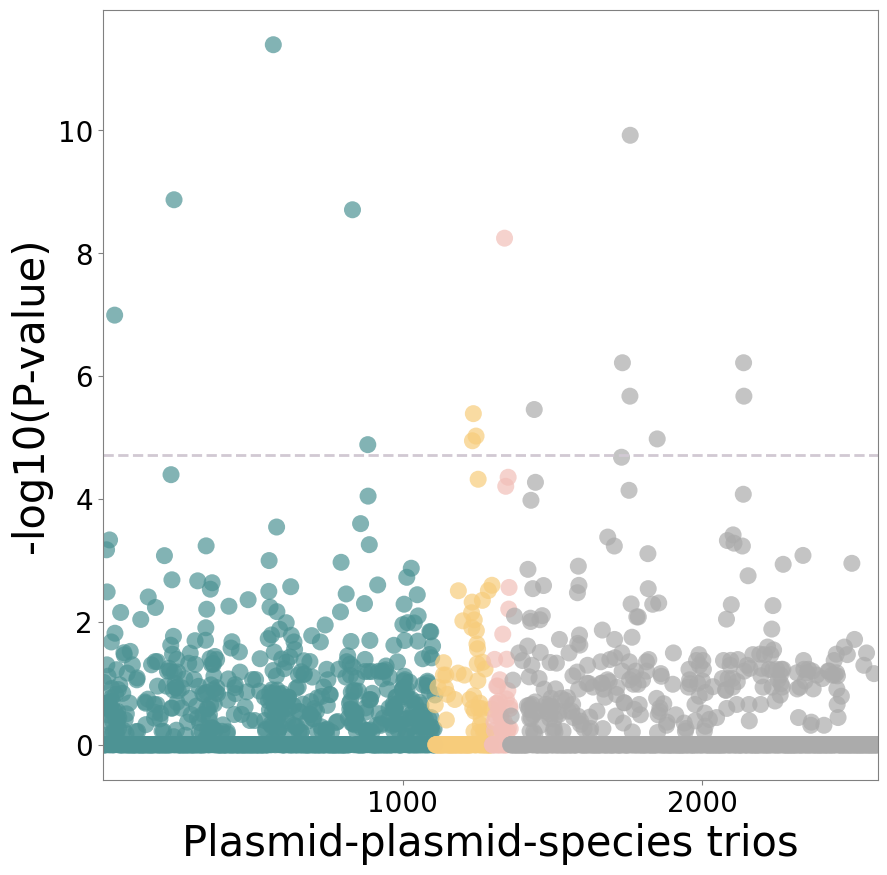

In [70]:
# 10. Plot Figure 3C

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, fisher_exact

# Initialize variables
plasmidplasmidspeciestrios = []
plasmidplasmidspeciestrios_pvalues={}
plasmidplasmidspeciestrios_mat={}
plasmidplasmidspeciestrios_sign={}
cases = 0
specieslistbyphylum = []
totalpylum = {}
Xvalues = []
Yvalues = []
Cs = []

# Calculate the total number of phyla
for species in Plasmid_DS_by_species:
    phylum = species_2_phylum[species]
    totalpylum[phylum] = 1

# Group species by phylum
for phylumtmp in Phylum_BHR_PID_list:
    for species in Plasmid_DS_by_species:
        phylum = species_2_phylum[species]
        if phylum == phylumtmp:
            specieslistbyphylum.append(species)

# Process each species in the list
for species in specieslistbyphylum:
    SpeciesLtCd = []
    
    # Filter good LtCd for the current species
    for LtCd in GoodLtCd:
        smp = ltcd_2_smp[LtCd]
        if smp_2_species[smp] == species:
            SpeciesLtCd.append(LtCd)
    
    # Analyze plasmid data for each species
    for ClusterID1 in Plasmid_DS_by_species[species]:
        for ClusterID2 in Plasmid_DS_by_species[species]:
            if ClusterID1 > ClusterID2 and len(SpeciesLtCd) > 10 and len(Plasmid_DS_by_species[species][ClusterID1]) > 2 and len(Plasmid_DS_by_species[species][ClusterID2]) > 2:
                cases += 1
                Xs = np.zeros(len(SpeciesLtCd))
                Ys = np.zeros(len(SpeciesLtCd))
                pmk = 0
                
                # Mark presence of plasmids in ClusterID1
                for PlLtCd in Plasmid_DS_by_species[species][ClusterID1]:
                    LtCd = PlLtCd.split('_')[0]
                    index1 = SpeciesLtCd.index(LtCd)
                    Xs[index1] = 1
                    if pmk == 0:
                        PlLtCd_1 = PlLtCd
                        pmk += 1
                
                # Mark presence of plasmids in ClusterID2
                pmk = 0
                for PlLtCd in Plasmid_DS_by_species[species][ClusterID2]:
                    LtCd = PlLtCd.split('_')[0]
                    index2 = SpeciesLtCd.index(LtCd)
                    Ys[index2] = 1
                    if pmk == 0:
                        PlLtCd_2 = PlLtCd
                        pmk += 1

                # Construct contingency matrix and calculate statistics
                mat = np.array([[0, 0], [0, 0]])
                for x, y in zip(Xs, Ys):
                    if x == y == 1:
                        mat[0][0] += 1
                    elif x == y == 0:
                        mat[1][1] += 1
                    elif x == 1:
                        mat[1][0] += 1
                    else:
                        mat[0][1] += 1
                
                rho, p = spearmanr(Xs, Ys)
                odds_ratio, p_value = fisher_exact(mat)

                # Assign color based on phylum
                phylum = species_2_phylum[species]
                color = phylum_colors.get(phylum, '#ABABAB')
                
                # Store values for plotting
                Xvalues.append(cases)
                Yvalues.append(-np.log10(p_value))
                Cs.append(color)
                trio = species+'+'+ClusterID1+'+'+ClusterID2
                plasmidplasmidspeciestrios_pvalues[trio]=p_value
                plasmidplasmidspeciestrios_mat[trio]=mat
                plasmidplasmidspeciestrios_sign[trio]=odds_ratio

# Set up the figure
fig, ax = plt.subplots(figsize=(10,10))  # Set the width and height in inches

# Create scatter plot
plt.scatter(Xvalues, Yvalues, color=Cs, alpha=0.7, marker='o', s=150,edgecolors='none')

# Set plot limits and draw a threshold line
plt.xlim(0, cases)
plt.plot([0, cases], [-np.log10(0.05 / cases), -np.log10(0.05 / cases)], '--', linewidth=2, color='#D1C9D3')

# Customize axis appearance
ax = plt.gca()
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.xaxis.set_tick_params(color='gray', direction='out')
ax.yaxis.set_tick_params(color='gray', direction='out')


# Change the font size of x-axis and y-axis labels
plt.xlabel("Plasmid-plasmid-species trios", fontsize=30)
plt.ylabel("-log10(P-value)", fontsize=30)

# Customize x-axis tick labels
x_ticks_positions = [1000,2000]  # Positions where custom labels will be placed
cus_x_ticks_positions = [10,100,600]
plt.xticks(x_ticks_positions, x_ticks_positions, fontsize=20)

# Customize x-axis tick labels
x_ticks_positions = [0,2,4,6,8,10]  # Positions where custom labels will be placed
cus_x_ticks_positions=["1K","10K","100K"]
plt.yticks(x_ticks_positions, x_ticks_positions, fontsize=20)



# Save the plot as a PDF file
plt.savefig('figures/Figure3C.pdf', dpi=600, bbox_inches='tight')
# Show


In [78]:
for trio in plasmidplasmidspeciestrios_pvalues:
    if plasmidplasmidspeciestrios_pvalues[trio]<(0.05 / 2500):
        if plasmidplasmidspeciestrios_sign[trio]>1:
            tmp = trio.split('+')
            print(tmp[0],'\t',tmp[1].split('_')[0],'\t',tmp[2].split('_')[0],'\t','positive','\t',plasmidplasmidspeciestrios_pvalues[trio])
        else:
            print(tmp[0],'\t',tmp[1].split('_')[0],'\t',tmp[2].split('_')[0],'\t','negative','\t',plasmidplasmidspeciestrios_pvalues[trio])


Parabacteroides_distasonis 	 PL-8 	 PL-3 	 positive 	 1.0145932774668262e-07
Bacteroides_ovatus 	 PL-6 	 PL-3 	 positive 	 1.3421591361062422e-09
Phocaeicola_vulgatus 	 PL-6 	 PL-3 	 positive 	 4.016210569222501e-12
Bacteroides_xylanisolvens 	 PL-6 	 PL-3 	 positive 	 1.953366301851529e-09
Bacteroides_thetaiotaomicron 	 PL-6 	 PL-3 	 positive 	 1.3025036459047202e-05
Bifidobacterium_longum 	 PL-302 	 PL-294 	 positive 	 1.1261757757097352e-05
Bifidobacterium_longum 	 PL-330 	 PL-294 	 positive 	 4.073562133267884e-06
Bifidobacterium_longum 	 PL-330 	 PL-294 	 negative 	 9.443312654356326e-06
Lactiplantibacillus_plantarum 	 PL-120 	 PL-119 	 positive 	 5.666622701947102e-09
Escherichia_coli 	 PL-163 	 PL-152 	 positive 	 3.4896158588956494e-06
Escherichia_coli 	 PL-211 	 PL-210 	 positive 	 6.045194843884052e-07
Escherichia_coli 	 PL-212 	 PL-210 	 positive 	 2.1158181953594187e-06
Escherichia_coli 	 PL-212 	 PL-211 	 positive 	 1.1972940839532689e-10
Escherichia_coli 	 PL-220 	 PL-159 

/var/folders/ll/dkgm259n293gyd5xz26_25p00000gq/T/ipykernel_44735/1882914893.py:20: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))


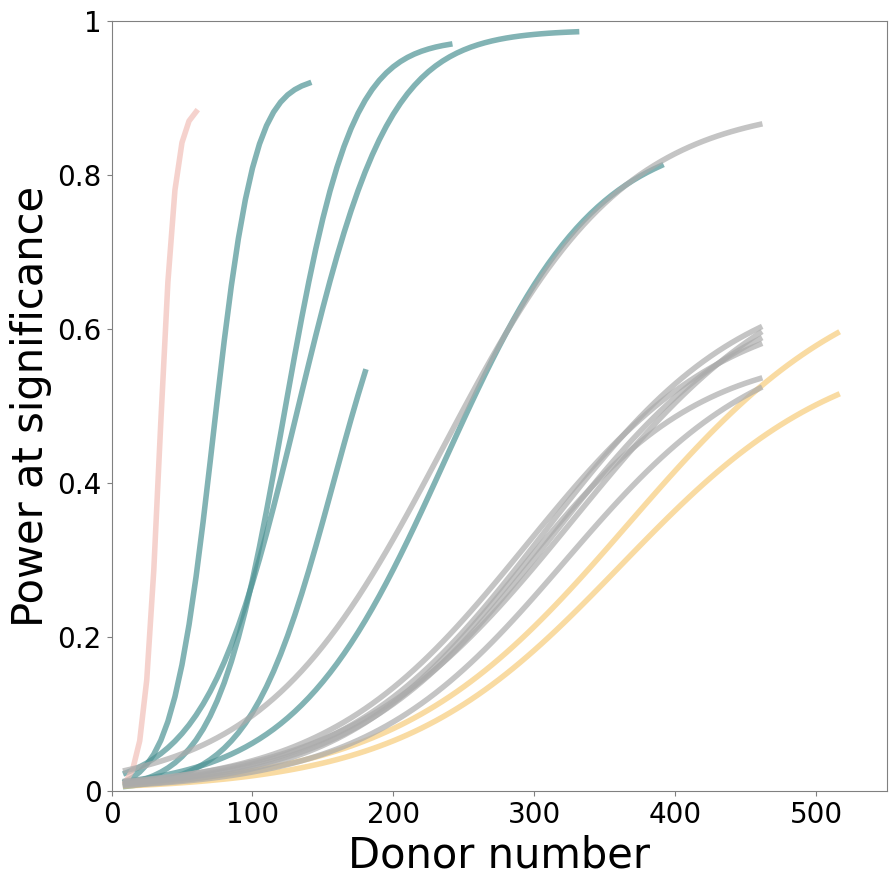

In [34]:
import numpy as np
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the sigmoidal function
def sigmoid(x, L, x0, k):
    """
    Sigmoidal function
    
    Parameters:
        x (array): Independent variable
        L (float): Maximum value of the sigmoidal curve
        x0 (float): Inflection point
        k (float): Rate of change
    
    Returns:
        array: Values of the sigmoidal function evaluated at x
    """
    return L / (1 + np.exp(-k * (x - x0)))

# Define your contingency table and p-value from Fisher's exact test
# For demonstration purposes, let's assume some random values
fig, ax = plt.subplots(figsize=(10,10))  # Set the width and height in inches

for trio in plasmidplasmidspeciestrios_mat:
    table = plasmidplasmidspeciestrios_mat[trio]
    sp = trio.split('+')[0]
    p_value = 0.05/2500
    # print(trio)
    if plasmidplasmidspeciestrios_pvalues[trio]<0.05/2500 and plasmidplasmidspeciestrios_sign[trio]>1:
        # plt.figure()
        # plt.title(trio)
        # Define a function to perform Fisher's exact test and compute power for a given sample size
        def compute_power(table, p_value, sample_size, iterations=100):
            # Initialize count of significant tests
            significant_tests = 0
            
            for _ in range(iterations):
                # Simulate data by resampling the contingency table
                simulated_data = np.random.multinomial(sample_size, table.ravel() / np.sum(table), size=1).reshape(table.shape)
                
                # Perform Fisher's exact test
                _, p_val = fisher_exact(simulated_data)
                
                # Check if the p-value is less than the threshold (usually 0.05)
                if p_val < p_value:
                    significant_tests += 1
            
            # Compute power as the proportion of significant tests
            power = significant_tests / iterations
            
            return power
        
        # Define sample sizes for subsampling
        sample_sizes = np.arange(10, np.sum(table), 5)
        
        # Compute power for each sample size
        powers = [compute_power(table, p_value, size) for size in sample_sizes]
        
        # # Plot power curve
        # plt.plot(sample_sizes, powers, marker='.')


        # Fit the sigmoidal curve to the data
        popt, pcov = curve_fit(sigmoid, sample_sizes, powers, p0=[max(powers), np.median(sample_sizes), 1])
        
        # Plot the original data
        # plt.scatter(sample_sizes, powers, label='Original Data')
        
        # Plot the fitted curve
        phylum = species_2_phylum[sp]
        color = phylum_colors[phylum]
        plt.plot(sample_sizes, sigmoid(sample_sizes, *popt), '-',linewidth=4,alpha=0.7,color=color)
        
        # plt.show()

# plt.grid(True)
# plt.show()
plt.xlim(0,550)
plt.ylim(0,1)


# Customize axis appearance
ax = plt.gca()
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.xaxis.set_tick_params(color='gray', direction='out')
ax.yaxis.set_tick_params(color='gray', direction='out')


# Change the font size of x-axis and y-axis labels
plt.xlabel("Donor number", fontsize=30)
plt.ylabel("Power at significance", fontsize=30)

# Customize x-axis tick labels
x_ticks_positions = [0,100,200,300,400,500]  # Positions where custom labels will be placed
cus_x_ticks_positions = [10,100,600]
plt.xticks(x_ticks_positions, x_ticks_positions, fontsize=20)

# Customize x-axis tick labels
x_ticks_positions = [0,.2,.4,.6,.8,1]  # Positions where custom labels will be placed
cus_x_ticks_positions=["1K","10K","100K"]
plt.yticks(x_ticks_positions, x_ticks_positions, fontsize=20)



# Save the plot as a PDF file
plt.savefig('Figures/FigureS3B.pdf', dpi=600, bbox_inches='tight')


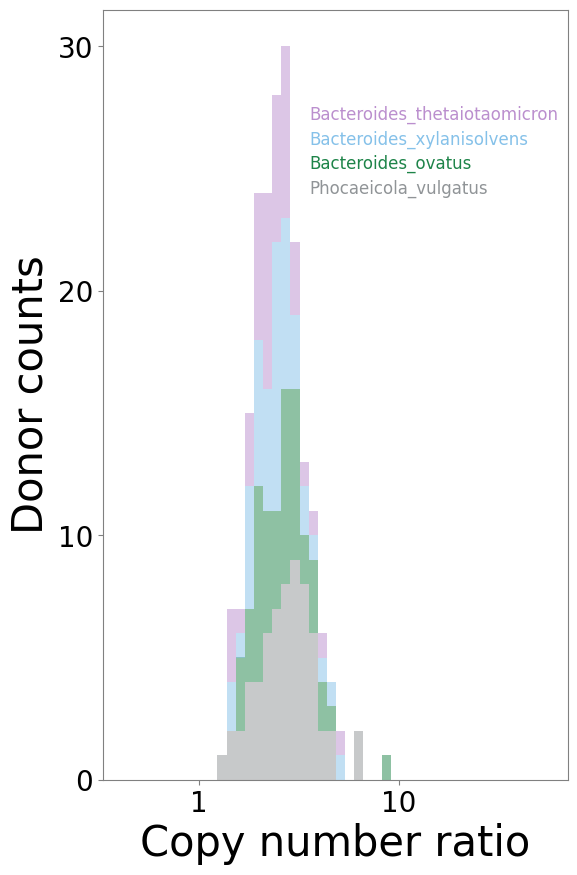

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Initialize figure with specified dimensions
fig, ax = plt.subplots(figsize=(6,10))  # Set the width and height in inches

# Define cluster IDs and species list
ClusterID1 = 'PL-6_2880'
ClusterID2 = 'PL-3_3998'
specieslist = ['Phocaeicola_vulgatus', 'Bacteroides_ovatus', 'Bacteroides_xylanisolvens', 'Bacteroides_thetaiotaomicron']

# Prepare data for each species
datas = []
for species in specieslist:
    data = []
    Cluster1species = {}
    Cluster2species = {}

    # Process Cluster1 data
    for PlLtCd in Plasmid_DS_by_species[species][ClusterID1]:
        LtCd = PlLtCd.split('_')[0]
        Cluster1species[LtCd] = PlLtCd

    # Process Cluster2 data
    for PlLtCd in Plasmid_DS_by_species[species][ClusterID2]:
        LtCd = PlLtCd.split('_')[0]
        Cluster2species[LtCd] = PlLtCd

    # Calculate log ratio for matching LtCd
    for LtCd in Cluster2species:
        if LtCd in Cluster1species:
            PlLtCd1 = Cluster1species[LtCd]
            PlLtCd2 = Cluster2species[LtCd]
            data.append(np.log10((plasmid_2_depth[PlLtCd1] / plasmid_2_depth[PlLtCd2])))
    datas.append(data)

# Convert lists to NumPy arrays
data1 = np.array(datas[0])
data2 = np.array(datas[1])
data3 = np.array(datas[2])
data4 = np.array(datas[3])

# Generate random colors for each histogram
colors = ['#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(4)]
colors = ['#F2F3F4','#D7DBDD','#BDC3C7','#909497']
colors = ['#909497','#1E8449','#85C1E9','#BB8FCE']

# Define bins for histogram
bins = np.linspace(min(data1.min(), data2.min(), data3.min(), data4.min()), 
                   max(data1.max(), data2.max(), data3.max(), data4.max()), 20)

# Helper function to calculate histogram counts
def get_hist_counts(data, bins):
    counts, _ = np.histogram(data, bins)
    return counts

# Calculate histogram counts for each dataset
counts1 = get_hist_counts(data1, bins)
counts2 = get_hist_counts(data2, bins)
counts3 = get_hist_counts(data3, bins)
counts4 = get_hist_counts(data4, bins)

# Function to update cumulative counts for stacking
cumulative_counts = np.zeros_like(counts1)
def stack_counts(counts):
    global cumulative_counts
    bottom = cumulative_counts
    cumulative_counts += counts
    return bottom

# Plotting the stacked histograms
plt.hist(bins[:-1], bins, weights=counts1, alpha=0.5, label=specieslist[0], color=colors[0])
plt.hist(bins[:-1], bins, weights=counts2, alpha=0.5, label=specieslist[1], color=colors[1], bottom=stack_counts(counts1))
plt.hist(bins[:-1], bins, weights=counts3, alpha=0.5, label=specieslist[2], color=colors[2], bottom=stack_counts(counts2))
plt.hist(bins[:-1], bins, weights=counts4, alpha=0.5, label=specieslist[3], color=colors[3], bottom=stack_counts(counts3))

for sp,color,i in zip(specieslist,colors,range(4)):
    plt.text(.55,24+i,sp,fontsize=12,color=color)
# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
# plt.title('Stacked Histogram')
# plt.legend()

# Customize axis appearance
ax = plt.gca()
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.xaxis.set_tick_params(color='gray', direction='out')
ax.yaxis.set_tick_params(color='gray', direction='out')

# Customize tick values and labels
custom_xticks = [np.log10(1), np.log10(3.3), np.log10(10)]
present_xticks = ['1', '3.3', '10']
plt.xticks(custom_xticks, present_xticks)



# Customize axis appearance
ax = plt.gca()
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.xaxis.set_tick_params(color='gray', direction='out')
ax.yaxis.set_tick_params(color='gray', direction='out')


# Change the font size of x-axis and y-axis labels
plt.xlabel("Copy number ratio", fontsize=30)
plt.ylabel("Donor counts", fontsize=30)

# Customize x-axis tick labels
x_ticks_positions = [np.log10(1), np.log10(10)] # Positions where custom labels will be placed
cus_x_ticks_positions = ['1', '10']
plt.xticks(x_ticks_positions, cus_x_ticks_positions, fontsize=20)

# Customize x-axis tick labels
x_ticks_positions = [0,10,20,30]  # Positions where custom labels will be placed
plt.yticks(x_ticks_positions, x_ticks_positions, fontsize=20)

plt.xlim(np.log10(0.33), np.log10(70))
plt.savefig('Figures/Figure3F.pdf', dpi=600, bbox_inches='tight')
# Show the plot
plt.show()


In [ ]:
## For generating the files for plotting trees
## 2. Read in mash-distance matrix
# import numpy as np

# sp = 'Bacteroides_ovatus'
# ClusterID1='PL-6_2880'
# ClusterID2='PL-3_3998'


# for trio in plasmidplasmidspeciestrios_pvalues:
#     if plasmidplasmidspeciestrios_pvalues[trio]<0.05/2500:
#         sp = trio.split('+')[0]
#         ClusterID1 = trio.split('+')[1]
#         ClusterID2 = trio.split('+')[2]
#         SpeciesLtCd=[]
#         for LtCd in GoodLtCd:
#             smp = ltcd_2_smp[LtCd]
#             if smp_2_sp[smp] == sp:
#                 SpeciesLtCd.append(smp)
                
#         # Create distance matrix with ones
#         dmatrix = np.ones((len(SpeciesLtCd), len(SpeciesLtCd)))
        
#         # Create a dictionary for quick lookup of smplist indices
#         smplist_dict = {smp: idx for idx, smp in enumerate(smplist)}
#         # subset_smplist_dict = {smp: idx for idx, smp in enumerate(SpeciesLtCd)}
        
        
#         # Open the file for reading
#         for smp1 in SpeciesLtCd:
#             for smp2 in SpeciesLtCd:
#                 idx_1 = smplist_dict.get(smp1)
#                 idx_2 = smplist_dict.get(smp2)
#                 i1 = SpeciesLtCd.index(smp1)
#                 i2 = SpeciesLtCd.index(smp2)
#                 dmatrix[i1,i2] = dist_matrix[idx_1, idx_2]
        
        
#         ##
#         # clusters = sch.linkage(dmatrix,method='ward')
#         clusters = hierarchy.linkage(dmatrix, method='centroid',metric='euclidean')
        
        
#         # for genomeid in genomelist:
#         #     donor = GenomeID_to_Donor[genomeid]
#         #     new_genemelist.append(donor + '_' + genomeid + '_' + genomeid_to_original_plate[genomeid] + '_' + genomeid_to_inter_plate[genomeid])
        
        
#         tree = hierarchy.to_tree(clusters, False)
#         leaf_names = SpeciesLtCd
#         tree_newick = get_newick(tree, tree.dist, leaf_names)
        
#         f = open('../Others/ggtree-pilot/plasmids-data/'+trio+ '.new.tree','w')
#         f.write(tree_newick)
#         f.close()
#         print(len(leaf_names))
#         Xs=np.zeros(len(SpeciesLtCd))
#         Ys=np.zeros(len(SpeciesLtCd))
        
#         for PlLtCd in Plasmid_DS_by_species[sp][ClusterID1]:
#             LtCd=PlLtCd.split('_')[0]
#             smp = ltcd_2_smp[LtCd]
#             index1 = SpeciesLtCd.index(smp)
#             Xs[index1]=Xs[index1]+2
            
#         for PlLtCd in Plasmid_DS_by_species[sp][ClusterID2]:
#             LtCd=PlLtCd.split('_')[0]
#             smp = ltcd_2_smp[LtCd]
#             index2 = SpeciesLtCd.index(smp)
#             Ys[index2]=Ys[index2]+1
        
#         f=open('../Others/ggtree-pilot/plasmids-data/'+trio+'plasmid-metadata.txt','w')
#         # f.write('id\t'+ClusterID1+'\t'+ClusterID2+'\n')
#         mk=1
#         for smp in SpeciesLtCd:
#             mk+=1
#             f.write(smp+'\t'+'TPHA_TPH1_DSM2243_NC_013204_2258\t')
#             f.write(str(100*Xs[SpeciesLtCd.index(smp)]+100)+'\t100.0\100.0\n')
#             f.write(smp+'\t'+'TPHB_TPH2_DSM2243_NC_013204_748\t')
#             f.write(str(100*Ys[SpeciesLtCd.index(smp)]+100)+'\t100.0\100.0\n')
#             f.write(smp+'\t'+'TDC_DSM2243_NC_013204_152\t')
#             f.write(str(100*Ys[SpeciesLtCd.index(smp)]+100)+'\t100.0\100.0\n')
#         f.close()
#         print(mk)
        


103